In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Reproduce Figure 1 

We generate 100 data points from the mixture Gaussian model with $\theta_1 = 0$ and $\theta_2 = 1$

In [2]:
rng = np.random.default_rng(4)
# observation stores my 100 data points
observation = []  
for i in range(100):
    u = rng.uniform(0, 1)
    if u<0.5:
        observation.append(rng.normal(0, np.sqrt(2)))
    else:
        observation.append(rng.normal(1,np.sqrt(2)))

Let's compute the actual posterior with 100 data points for verification purpose.

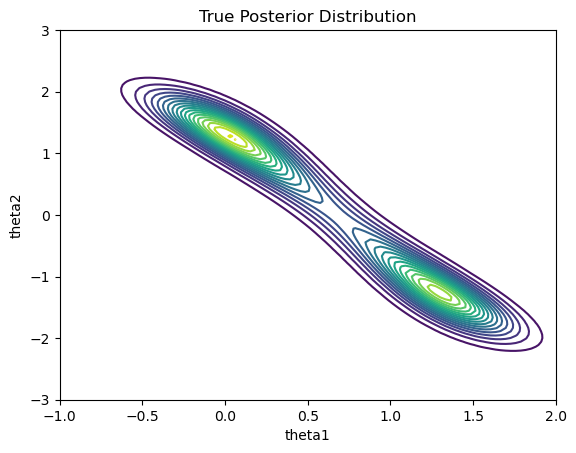

In [3]:
# sig1 is the standard deviation here
def prior1(theta1, sig1):
    return 1/(sig1*np.sqrt(2*np.pi)) * np.exp(-1/2 * (theta1/sig1)**2)

def prior2(theta2, sig2):
    return 1/(sig2*np.sqrt(2*np.pi)) * np.exp(-1/2 * (theta2/sig2)**2)

def likelihood(x, theta1, theta2, sigx):
    '''All inputs are numbers'''
    return 1/2 * 1/(sigx * np.sqrt(2*np.pi)) * np.exp(-1/2 * ((x-theta1)/sigx)**2) + \
            1/2 * 1/(sigx*np.sqrt(2*np.pi)) * np.exp(-1/2 * ((x - (theta1 + theta2))/sigx)**2)

def unnormalised_posterior(obs, theta1, theta2, sigx, sig1, sig2):
    '''obs(1D array): a collection of observations '''
    product = 1
    for x in obs:
        product = product * likelihood(x, theta1, theta2, sigx)
    return product * prior1(theta1,sig1) * prior2(theta2, sig2)

theta1_bb = np.linspace(-1, 2, 100)
theta2_bb = np.linspace(-3, 2.5, 100)
Theta1_bb , Theta2_bb = np.meshgrid(theta1_bb , theta2_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = unnormalised_posterior(obs = observation, theta1 = Theta1_bb[i,j] , theta2=Theta2_bb[i,j], sigx = np.sqrt(2), sig1=np.sqrt(10), sig2=1)

plt.contour(Theta1_bb, Theta2_bb, Z_bb, 20)  # Adjust the number of contours as needed

# Add labels for x and y axes
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.title("True Posterior Distribution")
#plt.axvline(x=0, color='red', linestyle='--')
#plt.axvline(x=1, color='red', linestyle='--')
 #Plot horizontal line at y = -1
#plt.axhline(y=1, color='green', linestyle='--')
#plt.axhline(y=-1, color='green', linestyle='--')
# plt.colorbar()
plt.xlim(-1,2)
plt.ylim(-3,3)
plt.show()

Now apply the stochastic gradient langevin algorithm as stated in 5.1

In [4]:
def grad_log_prior(theta, sig1, sig2):
    '''
    Compute the gradient of log prior.
    arguments:
    theta: 1D array with 2 element theta1 and theta2
    sig1: the standard deviation of theta 1 in prior
    sig2: the standard deviation of theta 2 in prior
    '''
    return np.array([-theta[0]/(sig1 ** 2), -theta[1]/(sig2 ** 2)])

def grad_log_lik(x, theta, sigx):
    '''
    Compute the gradient of log likelihood
    arguments:
    x(scalar): 1 data point/observation
    theta:1D array with 2 element theta1 and theta2
    '''
    exp1 = np.exp(-1/2 * ((x-theta[0])/sigx)**2)
    exp2 = np.exp(-1/2 * ((x-(theta[1]+theta[0]))/sigx)**2)
    denominator = exp1+exp2
    return np.array([ 1/(sigx**2) * ((x-theta[0]) * exp1 + (x-(theta[0]+theta[1]))*exp2)/denominator,\
                    1/(sigx**2) *  ((x-(theta[0]+theta[1])) * exp2)/denominator ])

# the step size epsilon_t where t is current number of iteration
def step_size(t, gam=0.55):
    """
    Compute step size at iteration t.
    """
    a = 0.01585
    b = 2.31066
    return a/((b+t)**gam)


def sgld_Gaussian(sig1 = np.sqrt(10), sig2=1, sigx=np.sqrt(2), data_size=100, \
                  batch_size=1, iteration = 10000, gam = 0.55):
    """
    Perform Stochastic Gradient Langevin Dynamics (SGLD) sampling for a Gaussian target distribution.

    Parameters
    ----------
    sig1 : float33
        Standard deviation of the prior distribution for the first parameter, default is sqrt(10).
    sig2 : float
        Standard deviation of the prior distribution for the second parameter, default is 1.
    sigx : float
        Standard deviation of the likelihood function, default is sqrt(2).
    data_size : int
        Number of data points/observations, default is 100.
    batch_size : int
        Size of the mini-batch for each iteration, default is 1.
    iteration : int
        Number of iterations for the SGLD algorithm, default is 10000.
    gam : float, optional
        Step size decay rate parameter, default is 0.55.

    Returns
    -------
    numpy.ndarray
        An array of shape (2, iteration+1) containing the samples of the parameters from the SGLD algorithm. 
        The first row corresponds to the samples of the first parameter and the second row to the samples of the second parameter.
    """
    # for replicable experiment we set a seed
    rng = np.random.default_rng(1)
     # this stores all our samples theta from SGlD
    SGLD_samples = np.zeros((2, iteration+1))
    
    #theta = np.array([rng.normal(0, sig1), rng.normal(0, sig2)]) # initial theta
    theta = np.array([0.5, 0])
    SGLD_samples[:,0] = theta # store initial theta into sample
    
    # perform iteration over time.
    for i in range(0,iteration):
        # each time of iteration, new mini batch is drawn randomly.
        Mini_batch = rng.choice(observation, batch_size, replace=False)
        # Compute the stochastic gradient of the log-posterior
        sgradient = grad_log_prior(theta,sig1, sig2) + (data_size/batch_size) * \
              np.sum([grad_log_lik(Mini_batch[j], theta, sigx) for j in range(len(Mini_batch))],axis=0)# for each row sum over the columns
        # update theta recursively 
        theta =  theta + (step_size(i, gam)/2) * (sgradient) + rng.normal(0, np.sqrt(step_size(i,gam)), 2)
        SGLD_samples[:, i+1] = theta
    return SGLD_samples


In [5]:
theta_samples = sgld_Gaussian(sig1 = np.sqrt(10), sig2=1, sigx=np.sqrt(2), data_size=100, \
                  batch_size=1, iteration = 10000, gam = 0.55)

In [6]:
mymap2 = plt.get_cmap("Greys")
m_c2 = mymap2(400)

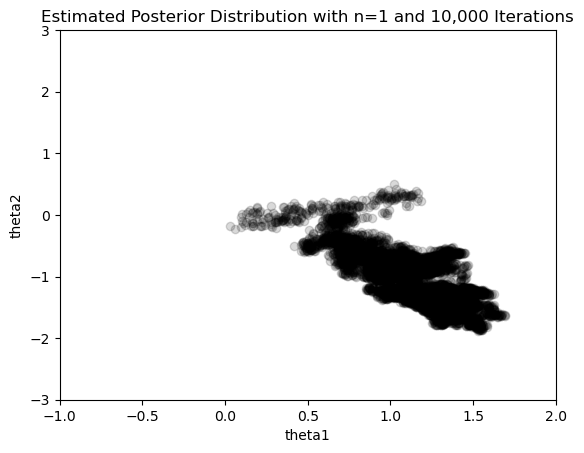

In [7]:
plt.scatter(theta_samples[0,:], theta_samples[1,:],color = m_c2, alpha =0.15) 
plt.title("Estimated Posterior Distribution with n=1 and 10,000 Iterations")
plt.xlim(-1,2)
plt.ylim(-3,3)
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.show()

# Adjustment

I found that I need to increase the number of iterations as it gets stuck at one mode and we do not get desired distribution. Now let's adjust the a and b accordingly and set iteration = 30000 and see what happens. 

Using a very small batch size can increase the variance of the gradient estimates, increase the batch size to 30.

if step size too small, it may not escape the attraction of the initial mode. Adjust the step size to be going from 0.01 to 0.0002 in the duration.

In [8]:
def step_size2(t, gam=0.55):

    a = 0.06
    b = 30
    return a/((b+t)**gam)

def sgld_Gaussian2(obs = observation, sig1 = np.sqrt(10), sig2=1, sigx=np.sqrt(2), data_size=100, \
                  batch_size=1, iteration = 10000, gam = 0.55):
    rng = np.random.default_rng(1)
    SGLD_samples = np.zeros((2, iteration+1)) # this stores all our samples theta from sdlg
                                             # row 1 is the theta1, row2 is theta2
    
    
    #theta = np.array([rng.normal(0, sig1), rng.normal(0, sig2)]) # initial theta
    theta = np.array([0.5, 0])
    SGLD_samples[:,0] = theta # store initial theta into sample
    
    # perform iteration over time.
    for i in range(0,iteration):
        # each time of iteration, new mini batch is drawn randomly.
        Mini_batch = rng.choice(obs, batch_size, replace=False)
        # Compute the stochastic gradient of the log-posterior
        sgradient = grad_log_prior(theta,sig1, sig2) + (data_size/batch_size) * \
              np.sum([grad_log_lik(Mini_batch[j], theta, sigx) for j in range(len(Mini_batch))],axis=0)# for each row sum over the columns
        # update theta recursively 
        theta =  theta + (step_size2(i, gam)/2) * (sgradient) + rng.normal(0, np.sqrt(step_size2(i,gam)), 2)
        SGLD_samples[:, i+1] = theta
    return SGLD_samples



In [9]:
theta_samples2 = sgld_Gaussian2(obs = observation, sig1 = np.sqrt(10), sig2=1, sigx=np.sqrt(2), data_size=100, \
                  batch_size=30, iteration = 30000, gam = 0.55)

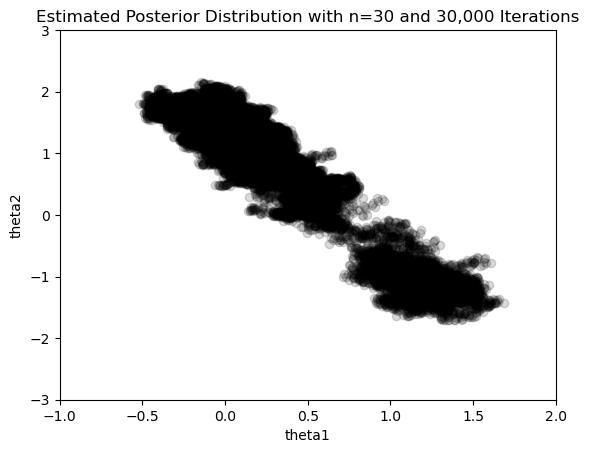

In [10]:
plt.scatter(theta_samples2[0,:], theta_samples2[1,:],color = m_c2, alpha =0.15) 
#plt.axvline(x=0, color='red', linestyle='--')
#plt.axvline(x=1, color='red', linestyle='--')
 #Plot horizontal line at y = -1
#plt.axhline(y=1, color='green', linestyle='--')
#plt.axhline(y=-1, color='green', linestyle='--')
plt.title("Estimated Posterior Distribution with n=30 and 30,000 Iterations")
plt.xlim(-1,2)
plt.ylim(-3,3)
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.show()

## Replicate figure 2 on the right

Now we fix the step size and compute the rejection rate using the gradient based proposal to observe how the average rejection rate changes as we decrease the step size.

Procedure:
1. Sample $\theta_n$ from the proposal(the stochastic gradient langevin algorithm)
2. draw a sample from uniform(0,1)
3. accept the sample $\theta_n$ if log(u) < acceptance probability,
$$ log (\frac{p(\theta') \prod_{i=1}^{N} p(x_i | \theta') q(\theta_t | \theta')}
{p(\theta_t) \prod_{i=1}^{N} p(x_i | \theta_t) q(\theta' | \theta_t)}) $$
otherwise reject. store our rejection rate(1-acceptance rate) in an array for average calculation later.
4. plot the average rejection rate against the the step size. 




In [11]:
# defined previously displayed here for information tracking. 

# sig1 is the standard deviation here

def prior1(theta1, sig1):
    return 1/(sig1*np.sqrt(2*np.pi)) * np.exp(-1/2 * (theta1/sig1)**2)

def prior2(theta2, sig2):
    return 1/(sig2*np.sqrt(2*np.pi)) * np.exp(-1/2 * (theta2/sig2)**2)

def likelihood(x, theta1, theta2, sigx):
    '''All inputs are numbers'''
    return 1/2 * 1/(sigx * np.sqrt(2*np.pi)) * np.exp(-1/2 * ((x-theta1)/sigx)**2) + \
            1/2 * 1/(sigx*np.sqrt(2*np.pi)) * np.exp(-1/2 * ((x - (theta1 + theta2))/sigx)**2)

def unnormalised_posterior(obs, theta1, theta2, sigx, sig1, sig2):
    '''obs(1D array): a collection of observations '''
    product = 1
    for x in obs:
        product = product * likelihood(x, theta1, theta2, sigx)
    return product * prior1(theta1,sig1) * prior2(theta2, sig2)

def grad_log_prior(theta, sig1, sig2):
    '''
    input:
    theta:1D array with 2 element theta1 and theta2
    returns an array with 2 elements
    '''
    return np.array([-theta[0]/(sig1 ** 2), -theta[1]/(sig2 ** 2)])

def grad_log_lik(x, theta, sigx):
    '''
    x(scalar): 1 data point
    theta:1D array with 2 element theta1 and theta2
    returns an array with 2 elements 
    '''
    exp1 = np.exp(-1/2 * ((x-theta[0])/sigx)**2)
    exp2 = np.exp(-1/2 * ((x-(theta[1]+theta[0]))/sigx)**2)
    denominator = exp1+exp2
    return np.array([ 1/(sigx**2) * ((x-theta[0]) * exp1 + (x-(theta[0]+theta[1]))*exp2)/denominator,\
                    1/(sigx**2) *  ((x-(theta[0]+theta[1])) * exp2)/denominator ])

In [12]:
# Define necessary functions.
def log_posterior(obs, theta1, theta2, sigx, sig1, sig2):
    return np.log(unnormalised_posterior(obs, theta1, theta2, sigx, sig1, sig2))

def stochastic_gradient(observation, theta, batch_size, sig1, sig2, sigx):
    Mini_batch = rng.choice(observation, batch_size, replace=False)
    # Compute the stochastic gradient of the log-posterior
    stochastic_gradient = grad_log_prior(theta,sig1, sig2) + (len(observation)/batch_size) * \
                    np.sum([grad_log_lik(Mini_batch[j], theta, sigx) for j in range(len(Mini_batch))], axis=0)
    return stochastic_gradient
def log_proposal(theta_prime, theta, step_size, observation, batch_size, sig1, sig2, sigx):
    inverse_cov = np.array([[1/step_size,0],[0, 1/step_size]])
    return -np.log(2*np.pi*step_size) - \
        1/2 * (theta_prime - theta - step_size/2 * stochastic_gradient(observation, theta, batch_size, sig1, sig2, sigx)).T @ inverse_cov@\
        (theta_prime - theta - step_size/2 * stochastic_gradient(observation, theta, batch_size, sig1, sig2, sigx))



In [18]:
def sgld_Gaussian_MH(obs = observation, sig1 = np.sqrt(10), sig2=1, sigx=np.sqrt(2), \
                  batch_size=1, iteration = 10000, step_size = 10**(-4)):
    rng = np.random.default_rng(1)
    SGLD_samples = np.zeros((2, iteration+1)) # this stores all our samples theta from sdlg
                                             # row 1 is the theta1, row2 is theta2
    
    
    #theta = np.array([rng.normal(0, sig1), rng.normal(0, sig2)]) # initial theta
    theta = np.array([0.5, 0])
    # store initial theta into sample
    SGLD_samples[:,0] = theta 
    # stores all rejection probabilities for each iteration
    rejection_prob = []
    # perform iteration over time.
    for i in range(1,iteration+1):
        # each time of iteration, new mini batch is drawn randomly.
        Mini_batch = rng.choice(obs, batch_size, replace=False)
        # Compute the stochastic gradient of the log-posterior
        sgradient = grad_log_prior(theta,sig1, sig2) + (len(obs)/batch_size) * \
              np.sum([grad_log_lik(Mini_batch[j], theta, sigx) for j in range(len(Mini_batch))],axis=0)# for each row sum over the columns
        # update theta recursively 
        theta =  theta + (step_size) * (sgradient) + rng.normal(0, np.sqrt(step_size), 2)
        
        # Metropolis step 
        
        #sample from uniform(0,1)
        u = rng.uniform(0, 1)
        # this is cuz I computed log but realised that I shouldn't.
        acceptance =  min(1, np.exp(log_posterior(obs, theta[0], theta[1], sigx, sig1, sig2) - \
                    log_posterior(obs, SGLD_samples[:,i-1][0], SGLD_samples[:,i-1][1], sigx, sig1, sig2)+ \
                    log_proposal(theta, SGLD_samples[:,i-1], step_size, obs, batch_size, sig1, sig2, sigx)- \
                    log_proposal(SGLD_samples[:,i-1], theta, step_size, obs, batch_size, sig1, sig2, sigx)))
        
        if u < acceptance :
        
            SGLD_samples[:, i] = theta
            rejection_prob.append(1-acceptance) # append the rejection rate. 
        else:
            SGLD_samples[:, i] = SGLD_samples[:, i-1]
            rejection_prob.append(1-acceptance) # append rejection rate
    # returns the samples and average of the rejection rate
    return SGLD_samples, np.mean(rejection_prob)


In [19]:
MH_sample, rejection = sgld_Gaussian_MH(obs = observation, sig1 = np.sqrt(10), sig2=1, sigx=np.sqrt(2), \
                  batch_size=1, iteration = 10000, step_size=10**(-4))

Text(0.5, 1.0, 'Stochastic gradient langevin with fixed step size and MH')

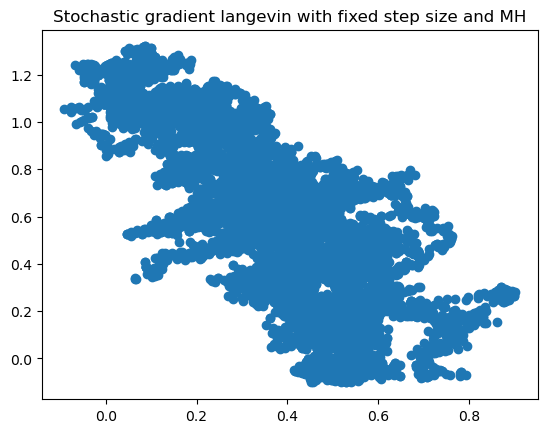

In [20]:
plt.scatter(MH_sample[0], MH_sample[1])
plt.title('Stochastic gradient langevin with fixed step size and MH')

In [22]:
# Now plot average rejection rate against the step size.
# 10,000 iterations in SGLD for each fixed step size.
step = np.linspace(10**(-8), 10**(-2), 2000)
average_rejection_rate = np.array([sgld_Gaussian_MH(obs = observation, sig1 = np.sqrt(10), sig2=1, sigx=np.sqrt(2), \
                  batch_size=1, iteration = 10000, step_size = step_i)[1] for step_i in step])
# only produced 2000 points because it takes too long. 

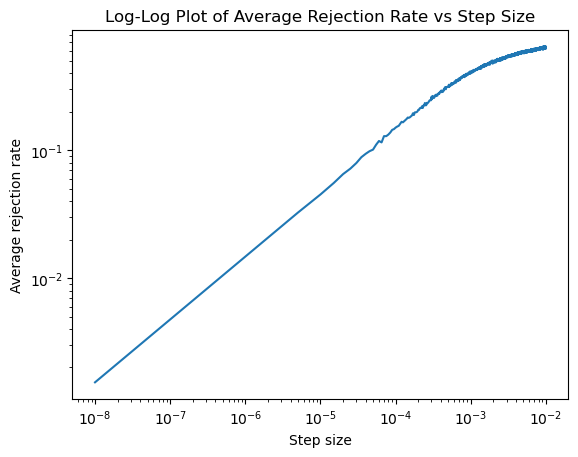

In [23]:
plt.loglog(step, average_rejection_rate)
plt.xlabel('Step size')
plt.ylabel('Average rejection rate')
plt.title('Log-Log Plot of Average Rejection Rate vs Step Size')
plt.show()

Successfully replicated right figure of figure 2.

# Reproduce figure 2 on the left

Calculate the variance of the stochastic gradient noise for each parameter θ1 and θ2 in a Bayesian learning context using Stochastic Gradient Langevin Dynamics.

The variance of the stochastic gradient noise represents the variability in the gradients due to the subsampling of the dataset.

The diagonal elements of the empirical covariance matrix provide the variance of the noise for each parameter due to stochastic gradient computation. 
i.e. The spread or noise in the gradient estimates for each individual parameter

In [206]:
def Variance_noises(theta, obs = observation, sig1 = np.sqrt(10), sig2=1, sigx=np.sqrt(2), \
                  batch_size=1, iteration = 10000, gam = 0.55):
    
    '''
    theta: initial value of theta we set
    Compute the empirical covariance matrix hence the variance of noises theta 1 and theta 2.
    return the step size over the number of iteration as well
    
    '''
    # 10 works , 26 works
    rng = np.random.default_rng(26)

    SGLD_samples = np.zeros((2, iteration+1)) # this stores all our samples theta from sdlg
                                             # row 1 is the theta1, row2 is theta2
    
    
    #theta = np.array([rng.normal(0, sig1), rng.normal(0, sig2)]) # initial theta
    SGLD_samples[:,0] = theta # store initial theta into sample
    # store the variance of theta 1 and theta 2 from stochastic gradient(grad of posterior)
    var1 = np.zeros(iteration)
    var2 = np.zeros(iteration)
    injected_noise_variance = np.zeros(iteration)
    # perform iteration
    # keep the updating process going
    for i in range(0,iteration):
        # each time of iteration, new mini batch is drawn randomly.
        Mini_batch = rng.choice(obs, batch_size, replace=False)
        
        # Implementing formula for empirical covariance
        
        # This array contains s_ti for all i by comprehension and broadcasting. This is a list of a 1D array of 2 elements 
        scores = np.array([grad_log_lik(Mini_batch[j], theta, sigx) for j in range(len(Mini_batch))]) + \
                                                            1/len(obs) * grad_log_prior(theta,sig1, sig2)
        
        empirical_mean = (1/len(Mini_batch)) * np.sum([score for score in scores], axis = 0)
        cov = ((len(obs)/len(Mini_batch))**2) * np.sum([np.outer((score - empirical_mean),(score - empirical_mean)) for score in scores], axis = 0)
        variance = (((step_size(i, gam))**2 )/ 4) * cov
        var1[i] = variance[0,0]
        var2[i] = variance[1,1]
        
        # Compute the stochastic gradient of the log-posterior
        sgradient = grad_log_prior(theta,sig1, sig2) + (len(obs)/batch_size) * \
              np.sum([grad_log_lik(Mini_batch[j], theta, sigx) for j in range(len(Mini_batch))],axis=0)# for each row sum over the columns
        # update theta recursively 
        theta =  theta + (step_size(i, gam)/2) * (sgradient) + rng.normal(0, np.sqrt(step_size(i,gam)), 2)
        injected_noise_variance[i] = step_size(i,gam)
        SGLD_samples[:, i+1] = theta
        
    return var1, var2, injected_noise_variance



In [207]:
var1, var2, injected_noise_variance = Variance_noises(np.array([0.5, 0]), obs = observation, sig1 = np.sqrt(10), sig2=1, sigx=np.sqrt(2), \
                  batch_size=4, iteration = 10000, gam = 0.55)

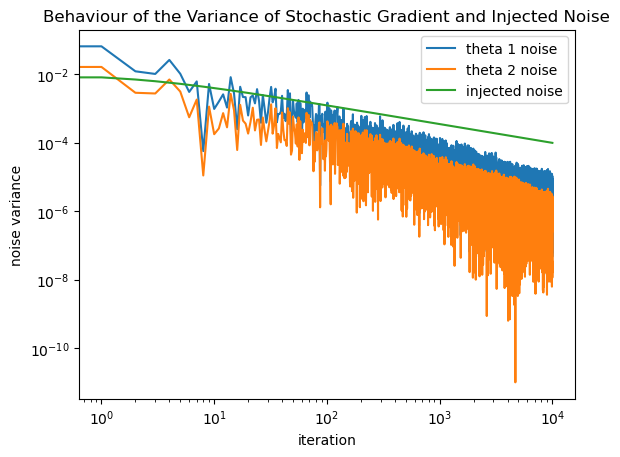

In [288]:
iteration_number = np.arange(10000)
plt.loglog(iteration_number, var1, label = 'theta 1 noise')
plt.loglog(iteration_number, var2, label = 'theta 2 noise')
plt.loglog(iteration_number, injected_noise_variance, label = 'injected noise')
plt.xlabel('iteration')
plt.ylabel('noise variance')
plt.title('Behaviour of the Variance of Stochastic Gradient and Injected Noise')
plt.legend()
plt.show()

The size of the mini-batch significantly influences the variance of the stochastic gradient. A larger batch size will generally reduce the variance of the stochastic gradient noise.

For most of batch size choices, the inject noise dominates the stochastic gradient noise throughout. The above example is very rare, need to keep batch number low to obtain higher initial variance. 

Only batch size 4 can obtain the desired property occasionally.